# Ground-state energies through ionic-relaxation path from pretrained m3gnet model

In [1]:
import numpy             as np
import ML_library        as MLL
import matplotlib.pyplot as plt
import matgl
import os
import warnings
import json

from __future__      import annotations
from matgl.ext.ase   import M3GNetCalculator, Relaxer
from pymatgen.io.ase import AseAtomsAdaptor

# To suppress warnings for clearer output
warnings.simplefilter('ignore')

In [2]:
model_save_path = 'finetuned_model'

# Define paths to pretrained model and structure to be relaxed
# Materials Project pretrained model as default
model_load_path = 'finetuned_model_1'
#model_load_path = None
model_load_path = 'M3GNet-MP-2021.2.8-PES' if model_load_path is None else model_load_path

dpi = 100

# Load the data from the JSON file
with open(f'{model_save_path}/model_parameters.json', 'r') as json_file:
    model_parameters = json.load(json_file)

# Load simulation data

In [3]:
# Extract the data
source_m3gnet_dataset = MLL.extract_vaspruns_dataset(model_parameters['path_to_dataset'], charged=model_parameters['charged'])
source_m3gnet_dataset


BiSBr
	as_1_Bi_on_S_0
	as_1_Bi_on_S_1
	as_1_S_on_Bi_-1
	as_1_S_on_Bi_3
	as_1_S_on_Bi_5
Error: vasprun not correctly loaded.
	inter_11_S_0
	inter_20_Br_0
	inter_21_Br_0
	vac_3_Br_-1
	vac_3_Br_0
	vac_3_Br_1


BiSBr  \
                                           BiSBr_as_1_Bi_on_S_0   
                                         BiSBr_as_1_Bi_on_S_0_0   
structure     [[2.97958563 2.32358318 5.42154828] Bi3+, [0.8...   
energy                                              -360.760545   
force         [[0.07207828, 0.0310842, 0.04972352], [-0.0055...   
stress        [[-2.1208515980000002, 0.010806431, -0.0143243...   
charge_state                                                0.0   

                                                                 \
                                                                  
                                         BiSBr_as_1_Bi_on_S_0_1   
structure     [[2.98097652 2.32418305 5.42250786] Bi3+, [0.8...   
energy                                              -360.763442   
force         [[0.06486033, 0.03654152, 0.0371568], [0.00147...   
stress        [[-2.1110432200000004, 0.010463909, -0.0126552...   
charge_state                                                0.0   

                                                                 \
                                                                  
                                         BiSBr_as_1_Bi_on_S_0_2   
structure     [[2.9851492  2.32598249 5.4253864 ] Bi3+, [0.8...   
energy                                              -360.768975   
force         [[0.03532649, 0.05397151, -0.00280999], [0.019...   
stress        [[-2.0844480300000003, 0.009275477, -0.0078117...   
charge_state                                                0.0   

                                                                 \
                                                                  
                                         BiSBr_as_1_Bi_on_S_0_3   
structure     [[2.99349468 2.32958154 5.43114348] Bi3+, [0.8...   
energy                                              -360.766246   
force         [[-0.01159648, 0.08372168, -0.07333601], [0.05...   
stress        [[-2.035588583, 0.007574436, 0.001602463000000...   
charge_state                                                0.0   

                                                                 \
                                                                  
                                         BiSBr_as_1_Bi_on_S_0_4   
structure     [[2.98802546 2.32722299 5.42737065] Bi3+, [0.8...   
energy                                              -360.770153   
force         [[0.02034077, 0.06407088, -0.02805642], [0.032...   
stress        [[-2.06438167, 0.008902324000000001, -0.004132...   
charge_state                                                0.0   

                                                                 \
                                                                  
                                         BiSBr_as_1_Bi_on_S_0_5   
structure     [[2.98996737 2.33020912 5.42707484] Bi3+, [0.8...   
energy                                              -360.772518   
force         [[0.01561428, 0.05459537, -0.01997754], [0.030...   
stress        [[-2.040863056, 0.008602743000000001, -0.00327...   
charge_state                                                0.0   

                                                                 \
                                                                  
                                         BiSBr_as_1_Bi_on_S_0_6   
structure     [[2.9957932  2.33916767 5.4261875 ] Bi3+, [0.8...   
energy                                              -360.776215   
force         [[0.0070201, 0.02717547, 0.00706469], [0.02906...   
stress        [[-1.9787528900000002, 0.008207387, -0.0001403...   
charge_state                                                0.0   

                                                                 \
                                                                  
                                         BiSBr_as_1_Bi_on_S_0_7   
structure     [[2.99709059 2.34116287 5.42598992] Bi3+, [0.8...   
energy                         

# Split data into train-validation-test sets

### Decide if we split in terms of mateiral, defect state or simulation directly

In [4]:
# Clone (copy) the DataFrame
m3gnet_dataset = source_m3gnet_dataset.copy()

# Remove the outer (top-level) column index up to depth-1 level
for i in range(model_parameters['depth']):
    m3gnet_dataset.columns = m3gnet_dataset.columns.droplevel(0)

### Splitting into train-validation-test sets

In [5]:
# Check if data has been already split, else do it randomly

path_to_test_labels = 'test_labels.txt'

if os.path.exists(path_to_test_labels):
    # Read labels splitting (which are strings)
    test_labels = np.genfromtxt(path_to_test_labels, dtype='str').tolist()
else:
    print('Error: test labels not available')

# Use the loaded/computed labels to generate split datasets
test_dataset = m3gnet_dataset[test_labels]

n_test = np.shape(test_dataset)[1]

print(f'Using {n_test} samples to test')

Using 43 samples to test


# Structure Relaxation

To perform structure relaxation, we use the Relaxer class. Here, we demonstrate the relaxation of a simple CsCl structure.

In [6]:
# Clear caché of previous model
matgl.clear_cache()

# Load the default pre-trained model
pot = matgl.load_model(model_load_path)
relaxer = Relaxer(potential=pot)

# Define the M3GNet calculator
calc = M3GNetCalculator(pot)

Do you really want to delete everything in /home/claudio/.cache/matgl (y|n)?  y


In [11]:
# Read top-level columns
upper_columns = [item[0] for item in m3gnet_dataset.columns]

# Define unique columns
unique_colums = np.unique(upper_columns)

In [8]:
plot_states = False

# Run over each ionic step and predict the energy with a single-shot calculation
offsets    = []
accuracies = []
for column_name in unique_colums:
    temp_data = m3gnet_dataset[column_name]
    
    # Initialize list for energies
    computed_energies  = []
    predicted_energies = []
    
    for i in range(np.shape(temp_data)[1]):
        # Load structure and computed (DFT) energy
        atoms           = temp_data.iloc[:, i].structure
        computed_energy = temp_data.iloc[:, i].energy

        # Load atoms adapter and adapt structure
        ase_adaptor = AseAtomsAdaptor()
        atoms = ase_adaptor.get_atoms(atoms)

        # Predict energy (ML-IAP)
        atoms.set_calculator(calc)
        predicted_energy = float(atoms.get_potential_energy())

        computed_energies.append(computed_energy)
        predicted_energies.append(predicted_energy)
    
    # Pass to numpy array
    computed_energies  = np.array(computed_energies)
    predicted_energies = np.array(predicted_energies)
    
    # Compute metrics
    offset   = MLL.compute_offset(computed_energies, predicted_energies)
    accuracy = MLL.compute_accuracy(computed_energies, predicted_energies, offset)
    
    # Append metrics
    offsets.append(offset)
    accuracies.append(accuracy)
    
    if plot_states:
        # Plot energy comparison
        plt.title(f'{column_name} ($d_1:$ {offset:.2g}, $d_2:$ {accuracy:.2g})')  # eV/supercell
        plt.plot(predicted_energies, '.', label='Predicted')
        plt.plot(computed_energies,  '.', label='Computed')
        plt.legend(loc='best')
        plt.xlabel('Ionic step')
        plt.ylabel('$E$ (eV/supercell)')
        plt.show()

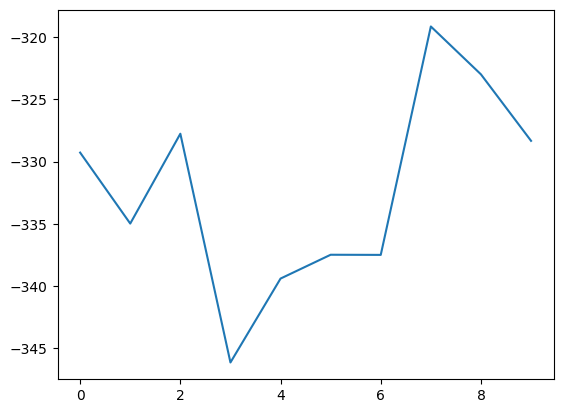

In [9]:
plt.plot(offsets)

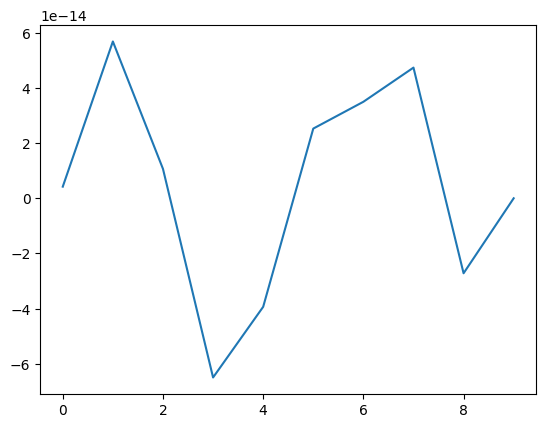

In [10]:
plt.plot(accuracies)